# Assignment 3

In this analysis five different datasets are selected from http://www.timeseriesclassification.com/. Several models are trained for each dataset. Two different representations each with two different parameter sets are used to build the model. Then, distances between the time series are calculated using 4 different distance measures. In the classification step, 3 different k values are used in the K-NN algorithm. Accuracy of each model is calculated to determine the best performing model. Finally, the best performing model is tested on a seperate test set.

In [48]:
library(data.table)
library(ggplot2)
library(TSrepr)
library(caret)
library(TSdist)
library(dtw)
library(zoo)
library(rpart)
library(rattle)
require(TunePareto)

setwd("C:/Users/alpsr/Desktop/Assignment 3")

## Dataset 5: Synthetic Control

In this notebook, Synthetic Control dataset is evaluated. This dataset contains 300 training time series and 300 test time series. There are 6 different classes. First six time series in the dataset are as follows.

In [49]:
dataset = 'SyntheticControl'
train_data_path=sprintf('%s/%s/%s_TRAIN.txt',getwd(),dataset,dataset)

In [50]:
syn = fread(train_data_path)
syn <- setnames(syn, "V1", "Class")
syn <- data.table(syn)
syn[, "ID" := 1:.N]
syn[, "Class" := as.factor(Class)]
setcolorder(syn, c("ID", "Class"))
colnames(syn) <- c("ID", "Class",seq(1:60))
syn_matrix <- as.matrix(syn[,c(-1,-2)])
syn_long <- melt(syn,id.vars = c("ID","Class"))
syn_long[,variable := as.numeric(variable)]
syn_class <- syn$Class
head(syn)

ID,Class,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,-0.3769356,1.22486430,0.3438744,0.3284540,-0.3376094,1.02651400,-1.3309960,-0.6578003,...,0.37071200,-1.5681650,1.02186260,-1.4297483,1.356966,1.3727813,0.6635578,0.9183460,-1.31174170,-1.19714620
2,1,0.6444062,0.41326914,-0.8622785,-1.4973857,-0.4214578,-0.21421485,-1.2921314,0.9568977,...,1.31726790,-0.8025282,-1.12128700,0.9893190,-1.109687,0.2198564,0.6300336,1.3981403,0.08574208,0.02499741
3,1,-0.9786674,-0.40623244,0.8224286,-1.4082424,-1.6767337,-0.49063202,1.4045976,1.1685996,...,-0.82878343,-0.7628843,1.38297230,-0.8691028,1.277252,-0.1989668,0.9668094,0.6661290,0.10699555,0.08271546
4,1,-0.2365366,-0.09817465,0.3670918,1.3668598,0.4982812,-0.30022317,1.7156337,0.9021076,...,0.06890446,-1.4996038,0.40674365,1.2891530,-1.119731,-0.9959846,1.6511352,-1.1870984,0.02546335,-0.84151833
5,1,1.4907351,1.32524300,1.6268292,-0.3170562,-1.0989904,-0.02221261,0.5969804,1.6673392,...,0.81506544,1.0299949,-1.49616070,-1.1674420,1.484208,-0.3730204,-0.8432813,-0.2097938,0.13772357,0.71654152
6,1,1.6433162,1.76401080,0.4377555,0.1993101,-1.5676161,-0.71911748,-1.0941885,1.0331764,...,0.28208201,-1.3686807,0.09789432,-0.4252310,0.575449,-0.9120210,1.3174235,-0.3972652,0.20926698,-0.04531146


## Classes

Six classes from the dataset are as follows.

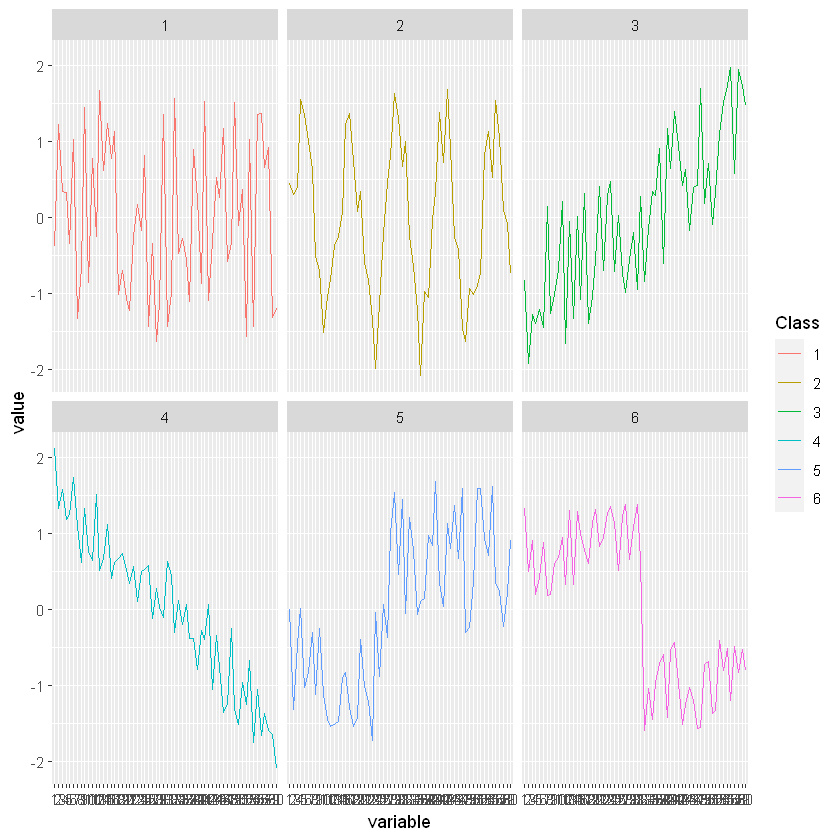

In [51]:
syn_class_1 <- melt(syn[,head(.SD, 1), Class],id.vars = c("ID","Class"))
ggplot(syn_class_1, aes(x = variable, y = value, group = Class)) +
geom_line(aes(color = Class))+
facet_wrap(vars(Class))

## Representations

Two different representations are used in this analysis. First one is PLA (piecewise linear approximation) and second is the APCA (Adaptive Piecewise Constant Approximation) using regression trees.

### Piecewise Linear Approximation

In [52]:
syn_pla_q12 <- repr_matrix(syn_matrix,repr_pla,args = list(times = 10, return = 'points'))
syn_pla_q6 <- repr_matrix(syn_matrix,repr_pla,args = list(times = 5,return = 'points'))

In [53]:
index1 = c(seq(1,59, by = 6),60)
for(i in seq(1,300)){
    syn_long[(variable %in% index1) & (ID == i), PLA_q12 := syn_pla_q12[i,]]
    syn_long[ID == i, PLA_q12_fit_value := syn_long[ID == i, na.approx(PLA_q12)]]
}

index2 = c(seq(1,59, by = 12),60)
for(i in seq(1,300)){
    syn_long[(variable %in% index2) & (ID == i), PLA_q6 := syn_pla_q6[i,]]
    syn_long[ID == i, PLA_q6_fit_value := syn_long[ID == i, na.approx(PLA_q6)]]
}

### Regression Trees

In [54]:
for(i in seq(1,300)){
    selected_series <- syn_long[ID == i]
    tree_fit=rpart(value~variable,selected_series,control=rpart.control(maxdepth=3, cp = 0, minsplit = 20, minbucket = 10))
    #fancyRpartPlot(tree_fit)
    syn_long[ID == i, Tree_fit_d3 := predict(tree_fit, selected_series)]
}

for(j in seq(1,300)){
    selected_series <- syn_long[ID == j]
    tree_fit=rpart(value~variable,selected_series,control=rpart.control(maxdepth=4, cp = 0, minsplit = 20, minbucket = 10))
    #fancyRpartPlot(tree_fit)
    syn_long[ID == j, Tree_fit_d4 := predict(tree_fit, selected_series)]
}

head(syn_long)

ID,Class,variable,value,PLA_q12,PLA_q12_fit_value,PLA_q6,PLA_q6_fit_value,Tree_fit_d3,Tree_fit_d4
<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,-0.3769356,-0.3769356,-0.3769356,-0.3769356,-0.3769356,0.39874855,0.39874855
2,1,1,0.6444062,0.6444062,0.6444062,0.6444062,0.6444062,-0.43892994,-0.43892994
3,1,1,-0.9786674,-0.9786674,-0.9786674,-0.9786674,-0.9786674,-0.37915240,-0.37915240
4,1,1,-0.2365366,-0.2365366,-0.2365366,-0.2365366,-0.2365366,0.39591243,0.39591243
5,1,1,1.4907351,1.4907351,1.4907351,1.4907351,1.4907351,0.30812580,0.30812580
6,1,1,1.6433162,1.6433162,1.6433162,1.6433162,1.6433162,-0.04912771,-0.04912771


## Distance Measures

Three different distances measures are used. First one is the Euclidean Distance. Remaining ones are Dynamic Time Warping (DTW), Longest Common Subsequence (LCSS) and Edit Distance with Real Penalties (ERP).

### Euclidean Distance

In [55]:
syn_euclidean_raw <- as.matrix(dist(syn_matrix))

syn_PLA_q12_matrix <- dcast(syn_long, ID + Class ~ variable, value.var = "PLA_q12_fit_value")
syn_PLA_q6_matrix <- dcast(syn_long, ID + Class ~ variable, value.var = "PLA_q6_fit_value")
syn_RegTree_d3_matrix <- dcast(syn_long, ID + Class ~ variable, value.var = "Tree_fit_d3")
syn_RegTree_d4_matrix <- dcast(syn_long, ID + Class ~ variable, value.var = "Tree_fit_d4")

syn_euclidean_pla_q12 <- as.matrix(dist(as.matrix(syn_PLA_q12_matrix[,c(-1,-2)])))
syn_euclidean_pla_q6 <- as.matrix(dist(as.matrix(syn_PLA_q6_matrix[,c(-1,-2)])))
syn_euclidean_RegTree_d3 <- as.matrix(dist(as.matrix(syn_RegTree_d3_matrix[,c(-1,-2)])))
syn_euclidean_RegTree_d4 <- as.matrix(dist(as.matrix(syn_RegTree_d4_matrix[,c(-1,-2)])))

### Dynamic Time Warping

In [ ]:
syn_dtw_pla_q12 <- as.matrix(TSDatabaseDistances(X = syn_PLA_q12_matrix[,c(-1,-2)], distance = 'dtw'))
syn_dtw_pla_q6 <- as.matrix(TSDatabaseDistances(X = syn_PLA_q6_matrix[,c(-1,-2)], distance = 'dtw'))
syn_dtw_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = syn_RegTree_d3_matrix[,c(-1,-2)], distance = 'dtw'))
syn_dtw_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = syn_RegTree_d4_matrix[,c(-1,-2)], distance = 'dtw'))
syn_dtw_raw <- as.matrix(TSDatabaseDistances(X = syn_matrix, distance = 'dtw'))

### LCSS

In [57]:
syn_lcss_raw <- as.matrix(TSDatabaseDistances(X = syn_matrix, distance = 'lcss', epsilon = 0.1))
syn_lcss_pla_q12 <- as.matrix(TSDatabaseDistances(X = syn_PLA_q12_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
syn_lcss_pla_q6 <- as.matrix(TSDatabaseDistances(X = syn_PLA_q6_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
syn_lcss_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = syn_RegTree_d3_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
syn_lcss_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = syn_RegTree_d4_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
#str(syn_lcss_pla_q12)

### ERP

In [58]:
syn_erp_raw <- as.matrix(TSDatabaseDistances(X = syn_matrix, distance = 'erp', g = 0))
syn_erp_pla_q12 <- as.matrix(TSDatabaseDistances(X = syn_PLA_q12_matrix[,c(-1,-2)], distance = 'erp', g = 0))
syn_erp_pla_q6 <- as.matrix(TSDatabaseDistances(X = syn_PLA_q6_matrix[,c(-1,-2)], distance = 'erp', g = 0))
syn_erp_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = syn_RegTree_d3_matrix[,c(-1,-2)], distance = 'erp', g = 0))
syn_erp_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = syn_RegTree_d4_matrix[,c(-1,-2)], distance = 'erp', g = 0))
#str(syn_erp_pla_q12)

## Generating Runs

After building the distance matrices, each model's performance is measured using the 10-fold stratified cross validation with 5 repeats.

### Cross-Validation Runs

In [59]:
set.seed(12435)
cv_indices = generateCVRuns(syn_class, ntimes = 5, nfold = 10, 
                            leaveOneOut = FALSE, stratified = TRUE)
str(cv_indices)

List of 5
 $ Run  1:List of 10
  ..$ Fold  1 : int [1:30] 24 50 36 38 34 57 92 85 64 74 ...
  ..$ Fold  2 : int [1:30] 17 45 13 23 32 94 63 61 100 73 ...
  ..$ Fold  3 : int [1:30] 1 19 15 46 28 90 95 84 99 76 ...
  ..$ Fold  4 : int [1:30] 6 43 31 26 21 54 89 97 72 70 ...
  ..$ Fold  5 : int [1:30] 29 8 48 33 9 58 93 88 79 87 ...
  ..$ Fold  6 : int [1:30] 41 39 18 20 12 60 77 81 52 65 ...
  ..$ Fold  7 : int [1:30] 10 47 42 25 3 71 96 80 82 68 ...
  ..$ Fold  8 : int [1:30] 16 4 44 27 14 91 86 67 56 98 ...
  ..$ Fold  9 : int [1:30] 30 37 2 49 11 62 66 55 69 51 ...
  ..$ Fold  10: int [1:30] 40 7 5 22 35 53 59 75 83 78 ...
 $ Run  2:List of 10
  ..$ Fold  1 : int [1:30] 32 36 42 14 25 66 89 72 77 65 ...
  ..$ Fold  2 : int [1:30] 27 8 31 13 6 84 95 86 76 55 ...
  ..$ Fold  3 : int [1:30] 33 37 11 49 17 74 81 99 94 96 ...
  ..$ Fold  4 : int [1:30] 10 29 41 39 7 80 91 53 98 51 ...
  ..$ Fold  5 : int [1:30] 24 38 46 12 9 57 68 97 92 69 ...
  ..$ Fold  6 : int [1:30] 45 43 21 1 18 79 5

### k-NN Classifier

In [60]:
nn_classify_cv=function(dist_matrix,train_class,test_indices,k=1){
    
    test_distances_to_train=dist_matrix[test_indices,]
    test_distances_to_train=test_distances_to_train[,-test_indices]
    train_class=train_class[-test_indices]
    ordered_indices=apply(test_distances_to_train,1,order)
    
    if(k==1){
        nearest_class=as.numeric(train_class[as.numeric(ordered_indices[1,])])
        nearest_class=data.table(id=test_indices,nearest_class)
    } else {
        nearest_class=apply(ordered_indices[1:k,],2,function(x) {train_class[x]})
        nearest_class=data.table(id=test_indices,t(nearest_class))
    }
    
    long_nn_class=melt(nearest_class,'id')

    class_counts=long_nn_class[,.N,list(id,value)]
    class_counts[,predicted_prob:=N/k]
    wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
    wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
    class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]
    
    
    return(list(prediction=class_predictions,prob_estimates=wide_class_prob_predictions))
    
}

### Testing the Models

In [61]:
dist = list(syn_euclidean_raw,
            syn_euclidean_pla_q12,
            syn_euclidean_pla_q6,
            syn_euclidean_RegTree_d3,
            syn_euclidean_RegTree_d4,
            syn_dtw_raw,
            syn_dtw_pla_q12,
            syn_dtw_pla_q6,
            syn_dtw_RegTree_d3,
            syn_dtw_RegTree_d4,
            syn_lcss_raw,
            syn_lcss_pla_q6,
            syn_lcss_pla_q12,
            syn_lcss_RegTree_d3,
            syn_lcss_RegTree_d4,
            syn_erp_raw,
            syn_erp_pla_q6,
            syn_erp_pla_q12,
            syn_erp_RegTree_d3,
            syn_erp_RegTree_d4)

n_dist = 15
nof_rep = 5
n_fold = 10
k_levels=c(1,5,10)
result = vector('list',n_dist*nof_rep*n_fold*length(k_levels))
iter = 1
names = c("syn_euclidean_raw","syn_euclidean_pla_q12","syn_euclidean_pla_q6",
         "syn_euclidean_RegTree_d3","syn_euclidean_RegTree_d4",
         "syn_dtw_raw","syn_dtw_pla_q12","syn_dtw_pla_q6","syn_dtw_RegTree_d3",
         "syn_dtw_RegTree_d4","syn_lcss_raw","syn_lcss_pla_q6","syn_lcss_pla_q12",
         "syn_lcss_RegTree_d3","syn_lcss_RegTree_d4","syn_erp_raw","syn_erp_pla_q6",
         "syn_erp_pla_q12","syn_erp_RegTree_d3","syn_erp_RegTree_d4")

In [62]:
CrossValidationTrain <- function(dist,cv_index, train_class){
    n_dist = 20
    nof_rep = 5
    n_fold = 10
    k_levels=c(1,5,10)

    for(m in 1:n_dist){ #
        current_dist = dist[[m]]
        for(i in 1:nof_rep){
            this_fold=cv_index[[i]]
            for(j in 1:n_fold){
                test_indices=this_fold[[j]]
                for(k in 1:length(k_levels)){
                    current_k=k_levels[k]
                    current_fold=nn_classify_cv(current_dist,train_class,test_indices,k=current_k)
                    accuracy=sum(train_class[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                    tmp=data.table(approach=names[[m]],repid=i,foldid=j,
                                   k=current_k,acc=accuracy)
                    
                    result[[iter]]=tmp
                    iter=iter+1
                }
            }
        }   
    }
    return(result)
}

Mean and standart deviation of each model is reported below. The best performing model is ERP distance on the raw time series with a 1-NN classifier. Its mean accuracy is 98.87%.

In [66]:
result_syn = CrossValidationTrain(dist,cv_indices, syn_class)
results_syn = rbindlist(result_syn)

results_summary <- results_syn[,.(Mean = mean(acc),SD = sd(acc)),.(approach,k)]
results_summary[order(-Mean)]

approach,k,Mean,SD
<chr>,<dbl>,<dbl>,<dbl>
syn_erp_raw,1,0.9886666667,0.019760470
syn_erp_raw,10,0.9873333333,0.017676868
syn_erp_raw,5,0.9806666667,0.023415792
syn_dtw_raw,5,0.9773333333,0.021759352
syn_dtw_raw,10,0.9680000000,0.027733752
syn_dtw_raw,1,0.9640000000,0.029230494
syn_euclidean_raw,1,0.9100000000,0.035154341
syn_erp_RegTree_d3,5,0.9066666667,0.047619048
syn_erp_RegTree_d4,5,0.9033333333,0.048210611


## Testing

In [67]:
test_data_path=sprintf('%s/%s/%s_TEST.txt',getwd(),dataset,dataset)

syn_train = fread(train_data_path)
syn_test = fread(test_data_path)

syn_test <- setnames(syn_test, "V1", "Class")
syn_train <- setnames(syn_train, "V1", "Class")

syn_test <- data.table(syn_test)
syn_train <- data.table(syn_train)

syn_test[, "ID" := (1:.N)+300]
syn_test[, "Class" := as.factor(Class)]
syn_train[, "ID" := (1:.N)]
syn_train[, "Class" := as.factor(Class)]

syn_comb <- rbindlist(list(syn_train,syn_test),use.names = TRUE)

setcolorder(syn_comb, c("ID", "Class"))
colnames(syn_comb) <- c("ID", "Class",seq(1:60))
syn_comb_matrix <- as.matrix(syn_comb[,c(-1,-2)])
syn_comb_long <- melt(syn_comb,id.vars = c("ID","Class"))
syn_comb_long[,variable := as.numeric(variable)]
syn_comb_class <- syn_comb$Class

test_index_final = seq(301,600)

syn_comb_erp_raw <- as.matrix(TSDatabaseDistances(X = syn_comb_matrix, distance = 'erp', g = 0))

overall_result <- nn_classify_cv(syn_comb_erp_raw,syn_comb_class,test_index_final,k=1)

In [71]:
Test_Accuracy <- sum(syn_comb_class[test_index_final]==overall_result$prediction$predicted)/length(test_index_final)
Test_Accuracy

[1] 0.9666667

Finally, the best performing model is used to classify the test data and its test accuracy is 96.99%

Summary of the best performing model is as follows:

In [73]:
Dataset <- "Synthetic Control"
Cross_Validation_Mean_Accuracy <- max(results_summary$Mean)
Distance = 'ERP'
Representation = 'Raw'
K = '1'
df <- data.frame(Dataset,Cross_Validation_Mean_Accuracy,Test_Accuracy,Distance,Representation,K)
df

Dataset,Cross_Validation_Mean_Accuracy,Test_Accuracy,Distance,Representation,K
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Synthetic Control,0.9886667,0.9666667,ERP,Raw,1
